# <center> Radial Exponential Map </center>

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import trange
from torch.utils.data import DataLoader
from itertools import cycle
from matplotlib import cm
from scipy.stats import gaussian_kde

from utils.NF_base import *
from utils.utils_vmf import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

See [1] for different ways to construct normalizing flows on the sphere. Namely, the first method transform the sphere into cylinders recursively and leverage a normalizing flow on the circle, when the second use exponential map flows. See [2] for a more general normalizing flow on arbitrary Riemannian manifolds.

For codes (in Jax), see https://github.com/facebookresearch/rcpm or https://github.com/katalinic/sdflows.

[1] Rezende, Danilo Jimenez, et al. "Normalizing flows on tori and spheres." International Conference on Machine Learning. PMLR, 2020.

[2] Cohen, Samuel, Brandon Amos, and Yaron Lipman. "Riemannian Convex Potential Maps." International Conference on Machine Learning. PMLR, 2021.

### Utils Sphere

In [3]:
def plot_sphere(data):
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:30j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="gray",alpha=0.03)

    ax.scatter(data[:,0], data[:,1], data[:,2], s=10)
    plt.show()

In [4]:
def spherical_to_euclidean(sph_coords):
    """
        https://github.com/katalinic/sdflows/blob/0f319d8ae6e2c858061a0a31880d4b70f69b6a64/utils.py#L4
    """
    if sph_coords.ndim == 1:
        sph_coords = np.expand_dims(sph_coords, 0)
        
    theta, phi = np.split(sph_coords, 2, 1)
    return np.concatenate((
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ), 1)

def spherical_to_euclidean_torch(x):
    if x.ndim == 1:
        x = x.reshape(1, -1)
    
    theta = x[:,0]
    phi = x[:,1]
    
    xx = torch.sin(phi)*torch.cos(theta)
    yy = torch.sin(phi)*torch.sin(theta)
    zz = torch.cos(phi)
    
    return torch.cat([xx[:,None],yy[:,None],zz[:,None]], dim=-1)

def euclidean_to_spherical(euc_coords):
    if euc_coords.ndim == 1:
        euc_coords = np.expand_dims(euc_coords, 0)
    x, y, z = np.split(euc_coords, 3, 1)
    return np.concatenate((
        np.pi + np.arctan2(-y, -x),
        np.arccos(z)
    ), 1)


def _plot_mollweide(heatmap):
    tt, pp = np.meshgrid(theta - np.pi, phi - np.pi / 2, indexing='ij')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='mollweide')
    ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)
    ax.set_axis_off()
    plt.show()
    
    
def projection_mollweide(target_fn, ax, vmax=None):
    density = target_fn(spherical_to_euclidean(tp))
    heatmap = density.reshape(2 * 100, 100)
    tt, pp = np.meshgrid(theta - np.pi, phi - np.pi / 2, indexing='ij')
    ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet,vmax=vmax)
    ax.set_axis_off()
    
    
def scatter_mollweide_ax(X_target, ax):    
    spherical_coords = euclidean_to_spherical(X_target)
    ax.scatter(spherical_coords[:,0]-np.pi, spherical_coords[:,1]-np.pi/2)
    ax.set_axis_off()
    
def scatter_mollweide(X_target, target_fn):
    density = target_fn(spherical_to_euclidean(tp))
    heatmap = density.reshape(2 * 100, 100)
    
    tt, pp = np.meshgrid(theta - np.pi, phi - np.pi / 2, indexing='ij')

    spherical_coords = euclidean_to_spherical(X_target)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='mollweide')
    ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)
    ax.scatter(spherical_coords[:,0]-np.pi, spherical_coords[:,1]-np.pi/2)
    
    ax.set_axis_off()
    plt.show()
    
    
theta = np.linspace(0, 2 * np.pi, 2 * 100)
phi = np.linspace(0, np.pi, 100)
tp = np.array(np.meshgrid(theta, phi, indexing='ij'))
tp = tp.transpose([1, 2, 0]).reshape(-1, 2)
    
def plot_target_density(target_fn):
    density = target_fn(spherical_to_euclidean(tp))
    heatmap = density.reshape(2 * 100, 100)
    _plot_mollweide(heatmap)

### Radial Exponential Map

The radial exponential map is defined in [1] as:
\begin{equation}
    z = f(x) = \exp_x(\nabla \phi(x)),
\end{equation}
where $\exp_x(v) = x\cos(\|v\|)+\frac{v}{\|v\|}\sin(\|v\|)$ and $\phi(x)=\sum_i \frac{\alpha_i}{\beta_i}e^{\beta_i (x^T\mu_i-1)}$ with $(\alpha_i)_i$, $(\beta_i)_i$ and $(\mu_i)_i$ are learnable parameters such that $\sum_i \alpha_i <1$, $\beta_i>0$ for all $i$ and $\mu_i\in\mathbb{R}^{d+1}$.

In this case, it can be shown that the density is obtained as 
\begin{equation}
    p_Z(z) = p_X(x) \det(E(x)^T J_f(x)^T J_f(x) E(x))^{-\frac12},
\end{equation}
where $J_f$ is the Jacobian in the embedded space and $E(x)$ is the matrix whose columns form an orthonormal basis of $T_xS^{d-1}$.

Rk: need to project $\nabla\phi(x)$ on $T_xS^{d-1}$ first.

In [5]:
class ExpMap(BaseNormalizingFlow):
    def __init__(self, dim, n_radial_components):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(n_radial_components, requires_grad=True) / n_radial_components)
        self.beta = nn.Parameter(torch.rand(n_radial_components, requires_grad=True))
        self.mus = nn.Parameter(torch.randn(n_radial_components, dim, requires_grad=True))
        
    def forward(self, x):
        # Enforce constraints of $\sum_k \alpha_k \leq 1; \forall \beta_k > 0$
        alpha = F.softmax(self.alpha, dim=-1)
        beta = F.softplus(self.beta)
        mus = F.normalize(self.mus, p=2, dim=-1)
        
        x.requires_grad_(True)
        phi = torch.sum((alpha/beta) * torch.exp(beta * (x@mus.T-1)), axis=-1)
#         grad_phi = torch.autograd.grad(phi.sum(), x)[0]
        grad_phi = (alpha * torch.exp(beta * (x@mus.T -1))) @ mus
        
        ## Projection on T_x S^d of \nabla \phi
        v = grad_phi -  torch.sum(x*grad_phi, axis=-1)[:,None]*x
        norm_v = torch.linalg.norm(v, dim=-1)[:,None]
        exp = x * torch.cos(norm_v) + (v/norm_v) * torch.sin(norm_v)

        ## Orthonormal basis T_x S^d        
        grad_phi_normalized = v/norm_v
        E = torch.dstack([grad_phi_normalized, torch.cross(x, grad_phi_normalized)])
                
        ## Compute Jf
        Jf = []
        for i in range(exp.shape[1]):
            Jf.append(torch.autograd.grad(exp[:, i].sum(), x, create_graph=True, retain_graph=True)[0])

        # Jf: (batch_size, d, d)
        Jf = torch.stack(Jf, dim=1)
                
        G = torch.matmul(Jf, E) 
        log_density = torch.logdet(torch.matmul(torch.transpose(G,1,2), G))/2
#         log_density = -torch.logdet(torch.matmul(torch.transpose(G,1,2), G))/2
        
        return exp, log_density    
    
    def backward(self, z):
        pass

### Optim Reverse KL

In [8]:
def kl_reverse(z, x, log_det, true_density): #, base_distr):
    """
        Inputs:
        - z: variable in the latent space
        - x: variable in the target space
        - log_det: log_det
        - true_density: function of the unnormalized density
        - base_distr

        Output:
        - "reversed" KL divergence
    """
#     log_pz = 0 # base_distr.log_prob(z)
    log_pz = np.log(1 / (4 * np.pi)) * torch.ones(z.shape[0], device=device)
    log_pX = torch.log(torch.clamp(true_density(x),min=1e-20)) ## only need unnormalized density
    return torch.mean(log_pz-log_det-log_pX,dim=0)

In [9]:
def kl_ess(log_model_prob, target_prob):
    weights = target_prob / np.exp(log_model_prob)
    Z = np.mean(weights)
    KL = np.mean(log_model_prob - np.log(target_prob)) + np.log(Z)
    ESS = np.sum(weights) ** 2 / np.sum(weights ** 2)
    return Z, KL, ESS

In [10]:
mus = torch.tensor([[1.5, 0.7+np.pi/2], [1, -1+np.pi/2], [5, 0.6+np.pi/2], [4, -0.7+np.pi/2]], device=device)
target_mus = spherical_to_euclidean_torch(mus)

def target_density(x):
    m = torch.matmul(x, target_mus.T)
    return torch.sum(torch.exp(10 * m), dim=-1)

In [11]:
target_mu = spherical_to_euclidean(np.array([
    [1.5, 0.7 + np.pi / 2],
    [1., -1. + np.pi / 2],
    [5., 0.6 + np.pi / 2],  # 0.5 -> 5.!
    [4., -0.7 + np.pi / 2]
]))

def s2_target(x):
    xe = np.dot(x, target_mu.T)
    return np.sum(np.exp(10 * xe), axis=1)

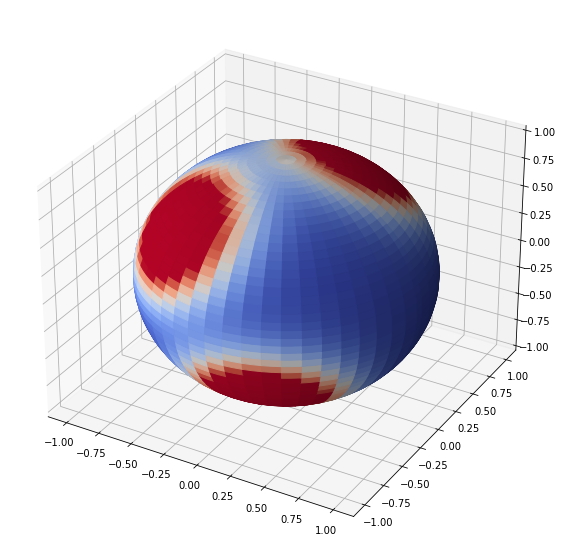

In [12]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)

grid = np.concatenate([x.flatten()[None,:].T, y.flatten()[None,:].T, z.flatten()[None,:].T], axis=1)
n, d = grid.shape
xs = torch.tensor(grid, dtype=torch.float).to(device)

# density_target = target_density(xs)
density_target = s2_target(xs.detach().cpu())
# heatmap = density_target.detach().cpu().reshape(100,100) # * 1000
heatmap = density_target.reshape(100,100)/10000 # * 1000

ax.plot_surface(x, y, z, facecolors=cm.coolwarm(heatmap))
plt.show()

/tmp/ipykernel_52851/3153928918.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


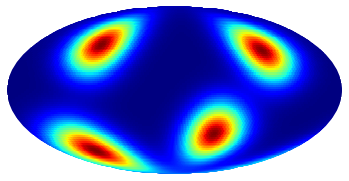

In [13]:
plot_target_density(s2_target)

In [14]:
d = 3
n_blocks = 1
n_components = 12

# n_blocks = 6
# n_components = 5

# n_blocks = 24
# n_components = 1

flows = []
for k in range(n_blocks):
    radialBlock = ExpMap(3, n_components)
    flows.append(radialBlock)
    
model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-4)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  60


  0%|          | 0/20001 [00:00<?, ?it/s]

k=0


/tmp/ipykernel_52851/3153928918.py:70: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


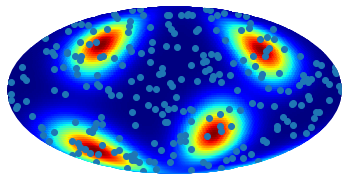

k=1000


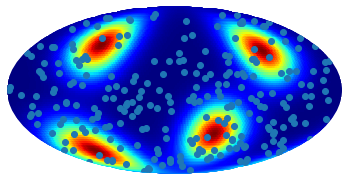

k=2000


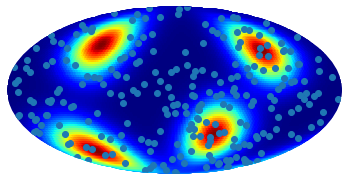

k=3000


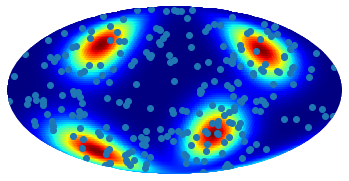

k=4000


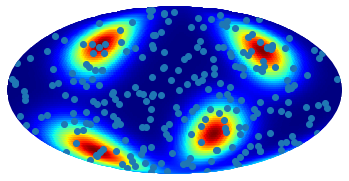

k=5000


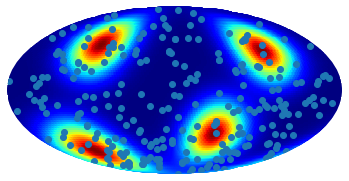

k=6000


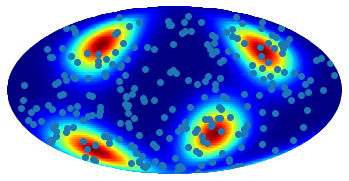

k=7000


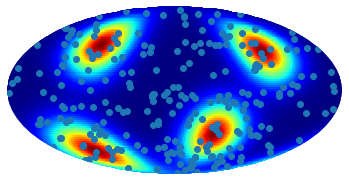

k=8000


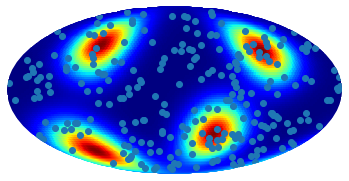

k=9000


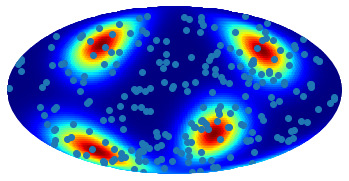

k=10000


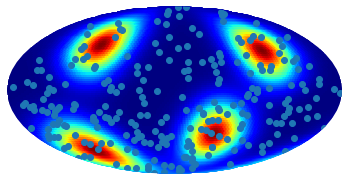

k=11000


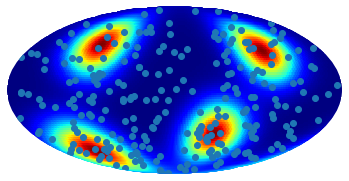

k=12000


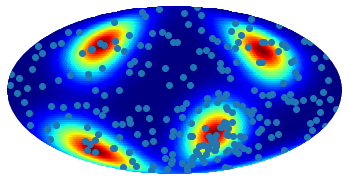

k=13000


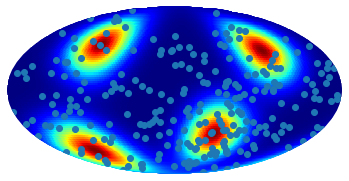

k=14000


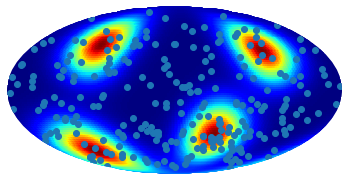

k=15000


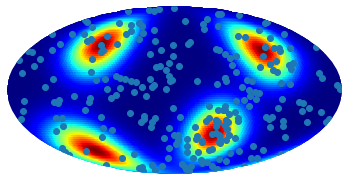

k=16000


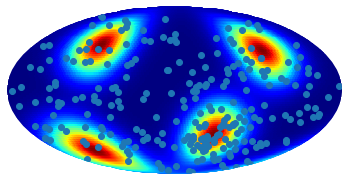

k=17000


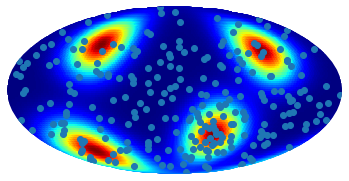

k=18000


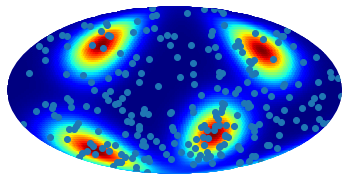

k=19000


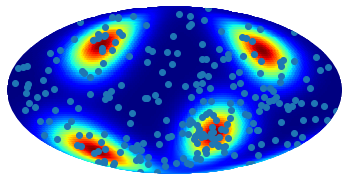

k=20000


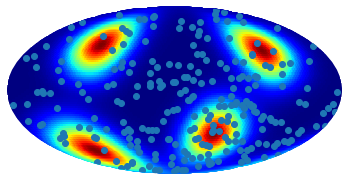

In [15]:
n_epochs = 20001
batch_size = 256

pbar = trange(n_epochs)

train_loss = []
L_ess = []
L_kl = []

for epoch in pbar:
    model.train()
    
    z = torch.randn((batch_size, d), device=device)
    z = F.normalize(z, p=2, dim=-1)
    
    x, log_det = model(z)
    l = kl_reverse(z, x[-1], log_det, target_density)
    
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_loss.append(l.item())
    
    if epoch%1000 == 0:
#         target = lambda x : target_density(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy()

#         plot_sphere(x[-1].detach().cpu())
        print("k="+str(epoch))
        scatter_mollweide(x[-1].detach().cpu(), s2_target)
        
    if epoch%50 == 0:
        x, log_det = model(z)
        log_prob = np.log(1 / (4 * np.pi)) * np.ones(z.shape[0]) - log_det.detach().cpu().numpy()

        _,  kl, ess = kl_ess(log_prob, s2_target(x[-1].detach().cpu().numpy()))
        
        pbar.set_postfix_str(f"loss = {l.item():.3f}, kl = {kl: .3f}, ess = {ess/batch_size * 100: .3f}")
        L_kl.append(kl)
        L_ess.append(ess/batch_size * 100)


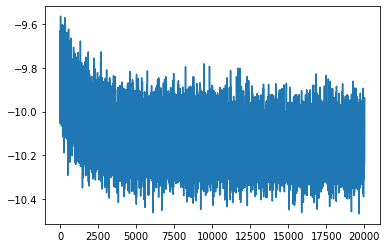

In [16]:
plt.plot(train_loss)
plt.show()

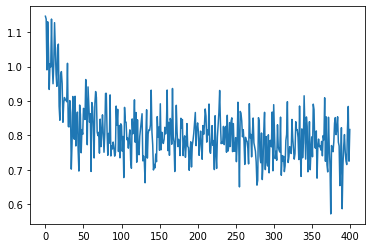

In [17]:
plt.plot(L_kl)
plt.show()

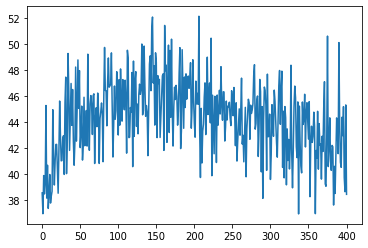

In [18]:
plt.plot(L_ess)
plt.show()

In [19]:
x, log_det = model(z)
log_prob = np.log(1 / (4 * np.pi)) * np.ones(z.shape[0]) - log_det.detach().cpu().numpy()

_,  kl, ess = kl_ess(log_prob, s2_target(x[-1].detach().cpu().numpy()))

print(kl, ess/batch_size * 100)

0.8169710235325898 38.41281411034678


/tmp/ipykernel_52851/3153928918.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


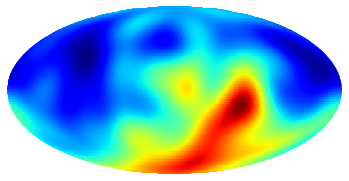

In [20]:
kernel = gaussian_kde(x[-1].T.detach().cpu())

density = kernel.pdf(spherical_to_euclidean(tp).T)
heatmap = density.reshape(2 * 100, 100)
_plot_mollweide(heatmap)

In [21]:
d = 3
# n_blocks = 1
# n_components = 12

n_blocks = 6
n_components = 5

# n_blocks = 24
# n_components = 1

flows = []
for k in range(n_blocks):
    radialBlock = ExpMap(3, n_components)
    flows.append(radialBlock)
    
model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=2e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-3)
print("number of params: ", sum(p.numel() for p in model.parameters()))


number of params:  150


  0%|          | 0/20001 [00:00<?, ?it/s]

k=0


/tmp/ipykernel_52851/3153928918.py:70: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


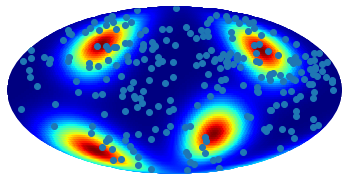

k=1000


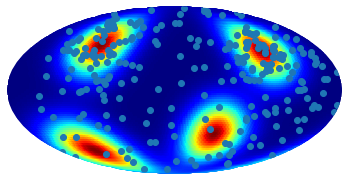

k=2000


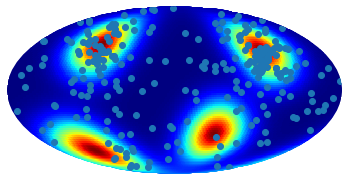

k=3000


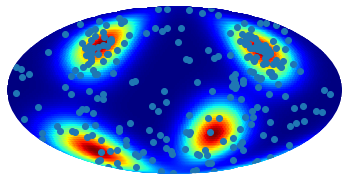

k=4000


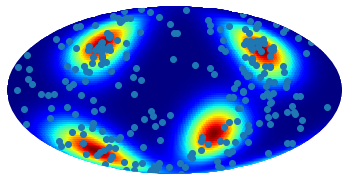

k=5000


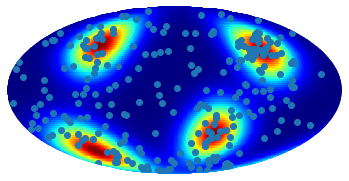

k=6000


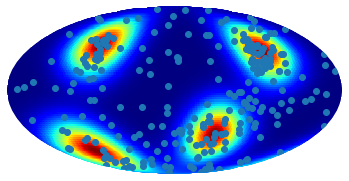

k=7000


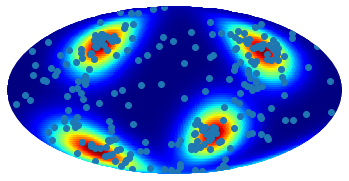

k=8000


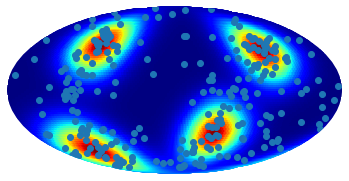

k=9000


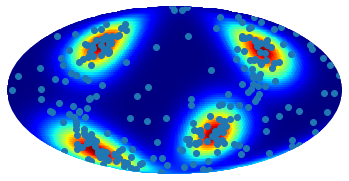

k=10000


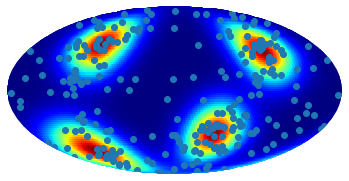

k=11000


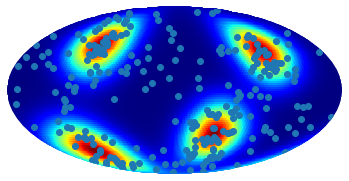

k=12000


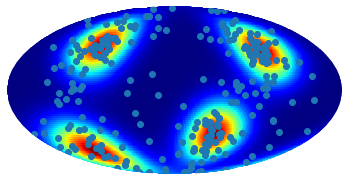

k=13000


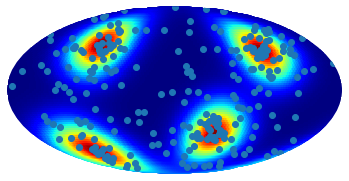

k=14000


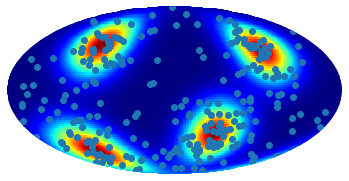

k=15000


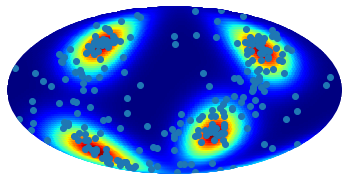

k=16000


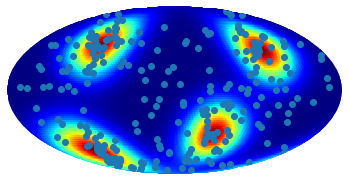

k=17000


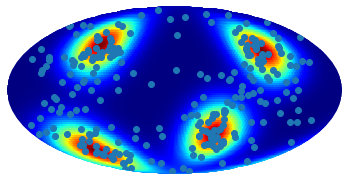

k=18000


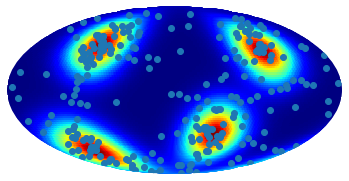

k=19000


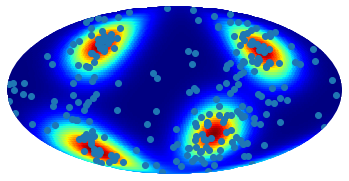

k=20000


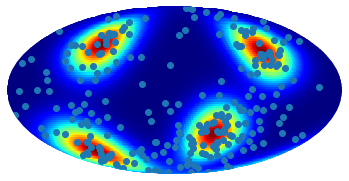

In [22]:
n_epochs = 20001 # 20000
batch_size = 256

pbar = trange(n_epochs)

train_loss = []
L_ess = []
L_kl = []

for epoch in pbar:
    model.train()
    
    z = torch.randn((batch_size, d), device=device)
    z = F.normalize(z, p=2, dim=-1)
    
    x, log_det = model(z)
    l = kl_reverse(z, x[-1], log_det, target_density)
    
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
        
    if epoch%1000 == 0:
#         target = lambda x : target_density(torch.tensor(x, dtype=torch.float, device=device)).cpu().numpy()

#         plot_sphere(x[-1].detach().cpu())
        print("k="+str(epoch))
        scatter_mollweide(x[-1].detach().cpu(), s2_target)
        
    if epoch%50 == 0:
        x, log_det = model(z)
        log_prob = np.log(1 / (4 * np.pi)) * np.ones(z.shape[0]) - log_det.detach().cpu().numpy()

        _,  kl, ess = kl_ess(log_prob, s2_target(x[-1].detach().cpu().numpy()))
        
        pbar.set_postfix_str(f"loss = {l.item():.3f}, kl = {kl: .3f}, ess = {ess/batch_size * 100: .3f}")
        L_kl.append(kl)
        L_ess.append(ess/batch_size * 100)
        
        train_loss.append(l.item())



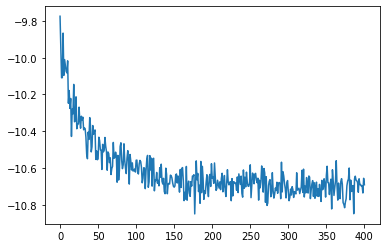

In [23]:
plt.plot(train_loss)
plt.show()

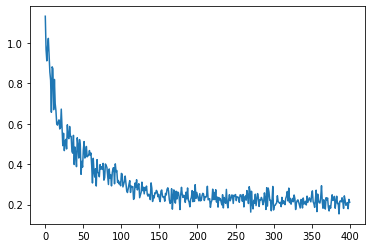

In [24]:
plt.plot(L_kl)
plt.show()

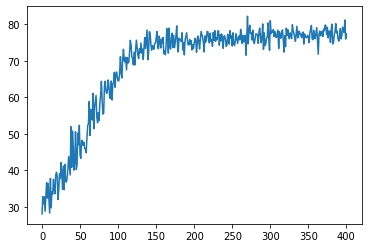

In [25]:
plt.plot(L_ess)
plt.show()

In [26]:
x, log_det = model(z)
log_prob = np.log(1 / (4 * np.pi)) * np.ones(z.shape[0]) - log_det.detach().cpu().numpy()

_,  kl, ess = kl_ess(log_prob, s2_target(x[-1].detach().cpu().numpy()))

print(kl, ess/batch_size * 100)

0.21150516852297763 77.29821152176707


/tmp/ipykernel_52851/3153928918.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(tt, pp, heatmap, cmap=plt.cm.jet)


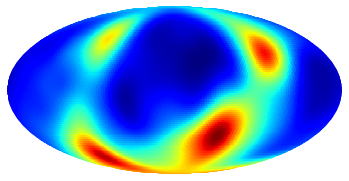

In [27]:
kernel = gaussian_kde(x[-1].T.detach().cpu())

density = kernel.pdf(spherical_to_euclidean(tp).T)
heatmap = density.reshape(2 * 100, 100)
_plot_mollweide(heatmap)